### Introduction

**What is Rasterization?** 🖼️
Rasterization is the process of converting geometric data (like the polygons representing your segmented nuclei) into a pixel-based grid. Your original Whole-Slide Image (WSI) is already a raster image — a large grid of pixels, each with a color value. Vectorized segmentation maps, on the other hand, define shapes using geometry objects such as polygons, points and lines.

Why is this important? Many analytical tasks, particularly those involving image intensity features, require the data to be aligned in the same format. For example, if you want to compute the average intensity of a stain within a specific nucleus, you need a pixel-by-pixel mask of that nucleus to apply to the corresponding region in the original WSI. Since your original image is a raster, your segmentation mask must also be a raster.

Histolytics supports the rasterization of vector segmentation maps, but it doesn't just rasterize; it also provides the ability to vectorize raster maps. This flexibility is a core strength of the package.

This bi-directional capability gives you the freedom to seamlessly move between the two data formats, enabling a wide range of analytical workflows. In this tutorial, we will explore how to rasterize vector segmentation maps and vectorize raster maps using Histolytics.

It should be noted, that rasterization can be applied only to a reasonable sized vector data. For example, full WSI-sized vector segmentation maps cannot be rasterized into a HxW sized raster mask, thus, patch-based rasterization is the recommended approach when working with large images. 

In this tutorial, we will showcase how vector data can be rasterized and vectorized back.

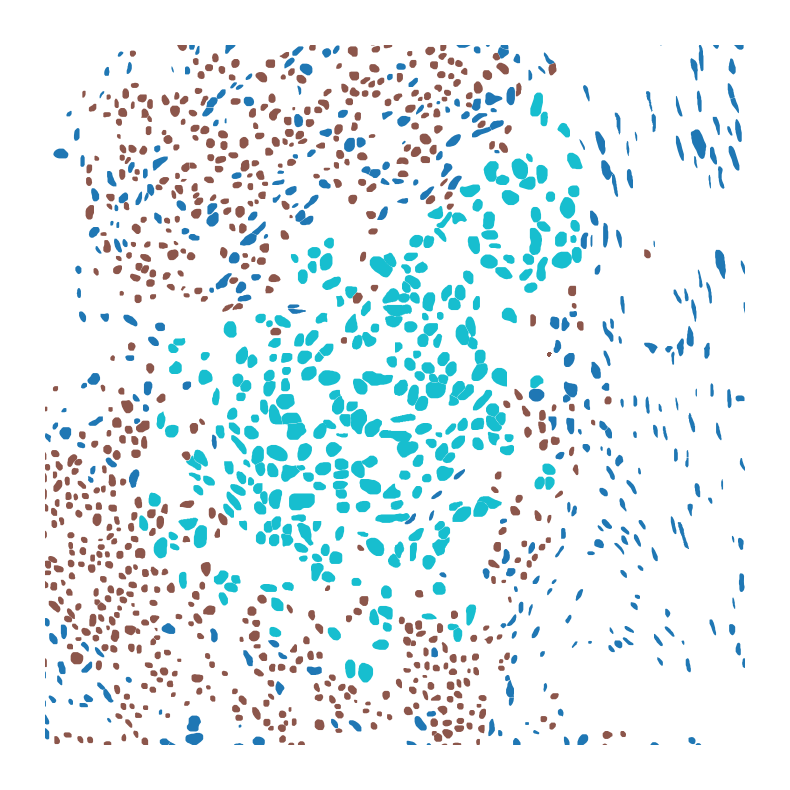

In [ ]:
# Let's load some vector data and the corresponding H&E image
from histolytics.data import hgsc_cancer_he, hgsc_cancer_nuclei

he = hgsc_cancer_he()  # Load the HE image
nuc = hgsc_cancer_nuclei()  # Corresponding nuclei vector segmentation

ax = nuc.plot(figsize=(10, 10), column="class_name")
ax.set_axis_off()

### Rasterizing a Vector Map

Histolytics contains two functions to convert vector segmentation maps to raster format and vice versa. These functions are:

1. `gdf2inst`: Converts a GeoDataFrame of instance segmentation masks to a rasterized instance mask.
2. `gdf2sem`: Converts a GeoDataFrame of semantic segmentation masks to a rasterized semantic mask.

If we want to preserve the instance information during rasterization, we should use `gdf2inst`. If we are only interested in the class labels, `gdf2sem` is the appropriate choice. In the next cell, we show how to use these functions to convert our vector segmentation maps to raster format. When using these functions, it's important to specify the target width and height of the rasterized output, which should match the dimensions of the original H&E image.

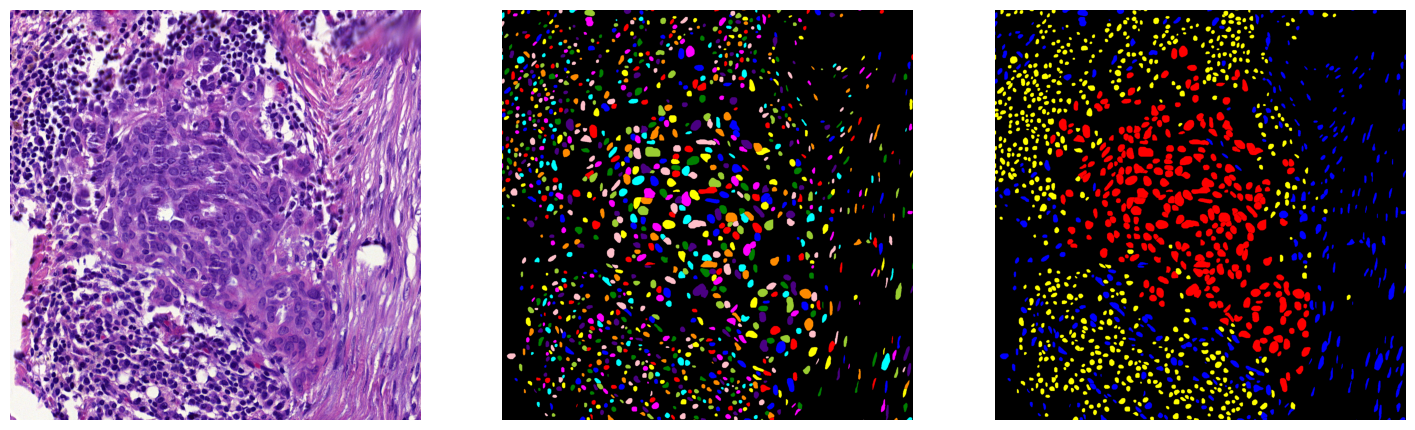

In [2]:
from histolytics.utils.raster import gdf2inst, gdf2sem
import matplotlib.pyplot as plt
from skimage.color import label2rgb


cls_dict = {
    "neoplastic": 1,
    "connective": 2,
    "inflammatory": 3,
}

# convert the nuclei gdf into raster mask
inst_mask = gdf2inst(nuc, width=he.shape[1], height=he.shape[0])
type_mask = gdf2sem(nuc, class_dict=cls_dict, width=he.shape[1], height=he.shape[0])

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(he)
ax[0].set_axis_off()
ax[1].imshow(label2rgb(inst_mask, bg_label=0, alpha=0.5))
ax[1].set_axis_off()
ax[2].imshow(label2rgb(type_mask, bg_label=0, alpha=0.5))
ax[2].set_axis_off()
plt.show()

### Converting a Subset of Nuclei to Raster

When converting to instance raster masks, the label ids are preserved from the original GeoDataFrame, allowing the tracking of individual instances at WSI-level. For example, if you want to compute intensity based features at WSI-level, you can convert the instance masks back to the original vector format once you are done without losing the correct nuclei instance ids. Or you can compute intensity based features on a subset of cells and then merge the resulting features back to the original GeoDataFrame, like this:

,geometry,class_name,mean_intensity
0,"POLYGON ((1394.01 0, 1395.01 1.99, 1398 3.99, ...",connective,NaN
1,"POLYGON ((1391 2.01, 1387 2.01, 1384.01 3.01, ...",connective,NaN
2,"POLYGON ((1382.99 156.01, 1380 156.01, 1376.01...",connective,NaN
3,"POLYGON ((1321 170.01, 1317.01 174.01, 1312.01...",connective,NaN
4,"POLYGON ((1297.01 0, 1299.01 2.99, 1302 5.99, ...",connective,NaN
...,...,...,...
1290,"POLYGON ((258 495, 258 496, 255 496, 255 497, ...",inflammatory,NaN
1291,"POLYGON ((855.25 359, 851 360.01, 849.01 361.0...",connective,NaN
1292,"POLYGON ((841 405, 841 406, 840 406, 840 407, ...",neoplastic,0.393750
1293,"POLYGON ((954 506, 954 507, 952 507, 952 508, ...",neoplastic,0.313959


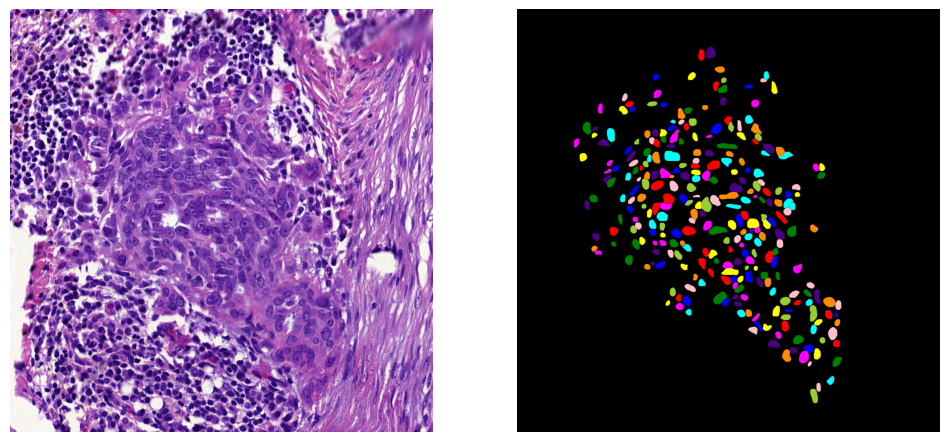

In [3]:
import scipy.ndimage as ndi
from skimage.color import rgb2gray
import numpy as np


# select only neoplastic nuclei
neo = nuc[nuc["class_name"] == "neoplastic"]
neo_inst_mask = gdf2inst(neo, width=he.shape[1], height=he.shape[0])

# Compute mean grayscale intensity of neoplastic nuclei:
mean_intensity = ndi.mean(
    rgb2gray(he), labels=neo_inst_mask, index=np.unique(neo_inst_mask)[1:]
)
neo = neo.assign(mean_intensity=mean_intensity)

# Set the mean_intensity values from neo to nuc
nuc.loc[neo.index, "mean_intensity"] = neo["mean_intensity"]

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(he)
ax[0].set_axis_off()
ax[1].imshow(label2rgb(neo_inst_mask, bg_label=0, alpha=0.5))
ax[1].set_axis_off()
nuc

### Vectorizing a Raster Instance Mask

To vectorize a raster instance mask, you can use the `inst2gdf` function. This function takes a raster mask as an input and returns a GeoDataFrame. 

Note 1: To preserve the nuclei type classes, the `inst2gdf` function takes in also the type_mask or the rasterized semantic nuclei type segmentation mask. If this is not passed, no nuclei type class information is added to the resulting GeoDataFrame.

Note 2: The `inst2gdf` applies a smoothing to smooth the nuclei borders after vectorization, since the vectorization process can create jagged edges. This can be turned off by setting the `smooth_func` parameter to None. The resulting GeoDataFrame will not be an exact copy of the original (original -> rasterized mask -> vectorized) GeoDataFrame, but the differences should be minimal.

,uid,class_name,geometry
290,0,connective,"POLYGON ((1394.4 0.6, 1394.6 0.9, 1394.9 1.2, ..."
296,1,connective,"POLYGON ((1385 2.6, 1384.6 2.9, 1384.1 3.2, 13..."
334,2,connective,"POLYGON ((1379.6 156.6, 1379.4 156.9, 1379.1 1..."
336,3,connective,"POLYGON ((1320.6 170.6, 1320.4 170.9, 1320.1 1..."
291,4,connective,"POLYGON ((1297.4 0.6, 1297.6 0.9, 1297.9 1.2, ..."
...,...,...,...
959,1290,inflammatory,"POLYGON ((256.8 495.6, 256.2 495.9, 255.4 496...."
380,1291,connective,"POLYGON ((852 359.6, 851.6 359.9, 851.1 360.2,..."
37,1292,neoplastic,"POLYGON ((840.6 405.6, 840.4 405.9, 840.1 406...."
66,1293,neoplastic,"POLYGON ((953.3 506.6, 953 506.9, 952.6 507.2,..."


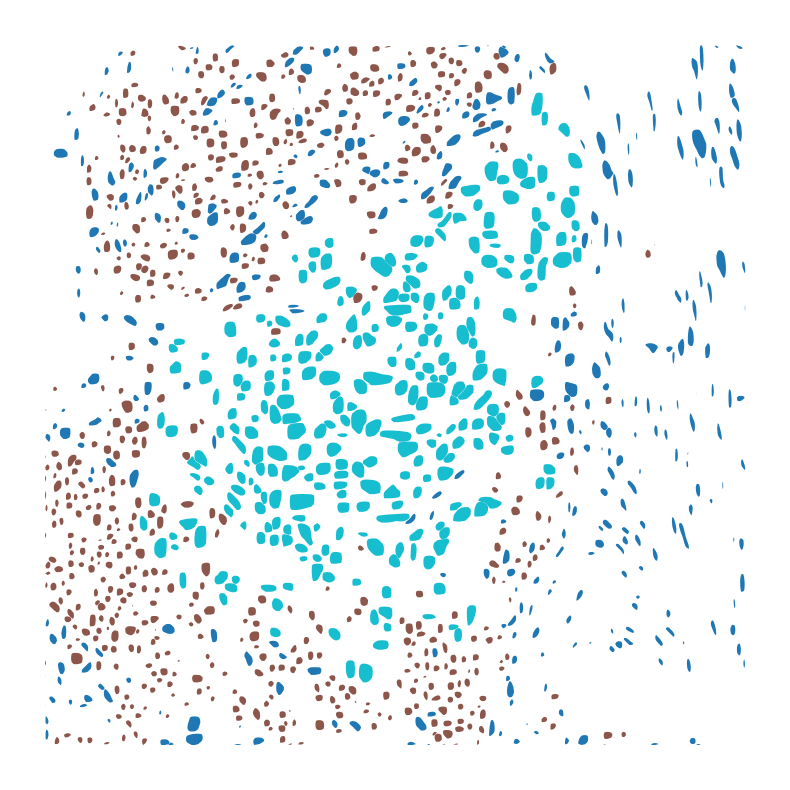

In [4]:
from histolytics.utils.raster import inst2gdf

# NOTE: when vectorizing, the class dict needs to have integer keys unlike when rasterizing.
cls_dict = {
    1: "neoplastic",
    2: "connective",
    3: "inflammatory",
}

nuc_vectorized = inst2gdf(inst_mask, type_map=type_mask, class_dict=cls_dict)
nuc_vectorized.sort_values(by="uid", inplace=True)
ax = nuc_vectorized.plot(figsize=(10, 10), column="class_name", aspect=1)
ax.set_axis_off()
nuc_vectorized

### Vectorizing a Raster Semantic Mask

To vectorize a raster semantic mask, you can use the `sem2gdf` function. This function takes a raster mask as an input and returns a GeoDataFrame. Typically you should use this function only to vectorize tissue segmentations rather than semantic nuclei type masks, but we'll showcase the usage using the semantic nuclei type mask. In the result, the overlapping nuclei will be merged due to the reason that `sem2gdf` does not handle instance level information, only class level information.

,uid,class_name,geometry
0,3,inflammatory,"POLYGON ((850.6 0.6, 851 0.9, 852 1.2, 853 1.4..."
1,3,inflammatory,"POLYGON ((1195.4 0.6, 1195.6 0.9, 1196.3 1.2, ..."
2,2,connective,"POLYGON ((405.5 0.6, 405.8 0.9, 406.7 1.2, 407..."
3,2,connective,"POLYGON ((818.4 1, 818.6 1.4, 819.2 1.8, 819.8..."
4,2,connective,"POLYGON ((1394.4 0.6, 1394.6 0.9, 1394.9 1.2, ..."
...,...,...,...
1224,2,connective,"POLYGON ((946.6 1496.6, 946.4 1497, 947 1497.4..."
1225,2,connective,"POLYGON ((1437.6 1492.6, 1437.4 1492.9, 1437.1..."
1226,3,inflammatory,"POLYGON ((293 1487.6, 292.6 1487.9, 292.1 1488..."
1227,2,connective,"POLYGON ((886.6 1494.6, 886.4 1494.9, 886.1 14..."


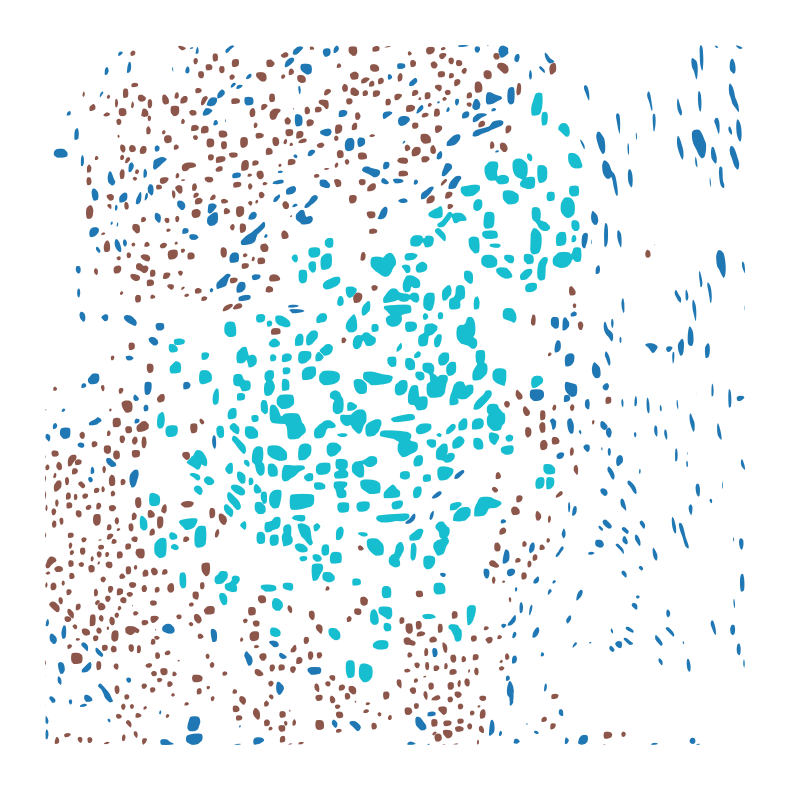

In [5]:
from histolytics.utils.raster import sem2gdf

# NOTE: when vectorizing, the class dict needs to have integer keys unlike when rasterizing.
cls_dict = {
    1: "neoplastic",
    2: "connective",
    3: "inflammatory",
}

nuc_type_vectorized = sem2gdf(type_mask, class_dict=cls_dict)
ax = nuc_type_vectorized.plot(figsize=(10, 10), column="class_name", aspect=1)
ax.set_axis_off()
nuc_type_vectorized

### Benchmark

Rasterizing and vectorizing is not free in terms of computation but still rather efficient. However, the run-times can get unreasonable when input sizes get too large or the number of nuclei is in the tens of thousands. 

Next we'll benchmark rasterization and vectorization using different image sizes to understand their performance characteristics. Rasterizing and vectorizing instance segmentations is typically more computationally intensive so we'll focus only on those.

In [20]:
from shapely.geometry import box


def crop_gdf(gdf, crop_size=1000):
    # Get the bounds of the H&E image
    h, w = he.shape[:2]

    # Calculate center crop coordinates
    x_center, y_center = w // 2, h // 2
    x_min = x_center - crop_size // 2
    y_min = y_center - crop_size // 2
    x_max = x_min + crop_size
    y_max = y_min + crop_size

    # Create bounding box for center crop
    crop_box = box(x_min, y_min, x_max, y_max)

    # Clip the nuclei to the center crop
    nuc_cropped = gdf.clip(crop_box)
    nuc_cropped = nuc_cropped.reset_index(drop=True)

    return nuc_cropped


nuc_1000x1000 = crop_gdf(nuc, 1000)
nuc_500x500 = crop_gdf(nuc, 500)

#### Rasterization Benchmark

In [21]:
%%timeit
gdf2inst(nuc, width=he.shape[1], height=he.shape[0])

146 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
gdf2inst(nuc_1000x1000, width=1000, height=1000)

65.4 ms ± 1.12 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [23]:
%%timeit
gdf2inst(nuc_500x500, width=500, height=500)

17 ms ± 185 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Benchmarking Vectorization

The vectorization process is a bit heavier than rasterization but we can still keep the run-times doable by again restricting the input sizes. We'll benchmark the vectorization process using the same image sizes as previously.

In [ ]:
def center_crop_raster(raster_mask, crop_size):
    h, w = raster_mask.shape[:2]

    crop_h = crop_w = crop_size

    # Calculate center crop coordinates
    y_center, x_center = h // 2, w // 2
    y_min = max(0, y_center - crop_h // 2)
    x_min = max(0, x_center - crop_w // 2)
    y_max = min(h, y_min + crop_h)
    x_max = min(w, x_min + crop_w)

    cropped_mask = raster_mask[y_min:y_max, x_min:x_max]

    return cropped_mask


inst_mask_1000x1000 = center_crop_raster(inst_mask, 1000)
inst_mask_500x500 = center_crop_raster(inst_mask, 500)
type_mask_1000x1000 = center_crop_raster(type_mask, 1000)
type_mask_500x500 = center_crop_raster(type_mask, 500)

In [37]:
%%timeit
inst2gdf(inst_mask, type_map=type_mask, class_dict=cls_dict)

388 ms ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%%timeit
inst2gdf(inst_mask_1000x1000, type_map=type_mask_1000x1000, class_dict=cls_dict)

175 ms ± 2.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [39]:
%%timeit
inst2gdf(inst_mask_500x500, type_map=type_mask_500x500, class_dict=cls_dict)

48.4 ms ± 550 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
